In [11]:
pip install category-encoders

                                              0.0/81.9 kB ? eta -:--:--
     ---------------------------------------- 81.9/81.9 kB 2.2 MB/s eta 0:00:00
                                              0.0/9.2 MB ? eta -:--:--
     -                                        0.3/9.2 MB 5.2 MB/s eta 0:00:02
     --                                       0.6/9.2 MB 8.1 MB/s eta 0:00:02
     ---                                      0.8/9.2 MB 7.0 MB/s eta 0:00:02
     ---                                      0.9/9.2 MB 5.1 MB/s eta 0:00:02
     ------                                   1.5/9.2 MB 6.4 MB/s eta 0:00:02
     --------                                 1.9/9.2 MB 6.7 MB/s eta 0:00:02
     ---------                                2.2/9.2 MB 7.0 MB/s eta 0:00:02
     ----------                               2.4/9.2 MB 7.1 MB/s eta 0:00:01
     ------------                             2.8/9.2 MB 6.8 MB/s eta 0:00:01
     --------------                           3.3/9.2 MB 7.2 MB/s eta 0:00:

In [14]:
pip install xgboost

                                              0.0/70.9 MB ? eta -:--:--
                                              0.1/70.9 MB 5.5 MB/s eta 0:00:13
                                              0.4/70.9 MB 5.0 MB/s eta 0:00:15
                                              1.4/70.9 MB 11.0 MB/s eta 0:00:07
     -                                        2.7/70.9 MB 15.4 MB/s eta 0:00:05
     --                                       3.9/70.9 MB 16.5 MB/s eta 0:00:05
     --                                       5.1/70.9 MB 18.2 MB/s eta 0:00:04
     ---                                      6.4/70.9 MB 20.4 MB/s eta 0:00:04
     ---                                      7.0/70.9 MB 19.6 MB/s eta 0:00:04
     ----                                     8.0/70.9 MB 19.7 MB/s eta 0:00:04
     -----                                    9.4/70.9 MB 20.0 MB/s eta 0:00:04
     -----                                   10.5/70.9 MB 23.4 MB/s eta 0:00:03
     -----                                   10.8/

In [22]:
pip install scikit-optimize

                                              0.0/100.3 kB ? eta -:--:--
     -----------------------------------     92.2/100.3 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 100.3/100.3 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [52]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

## Importing training data

In [61]:
# reading the original trainig data
train_df = pd.read_csv('data_sets/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [62]:
train_df.shape

(891, 12)

In [63]:
# Null values contained in each column
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Data cleaning

<Axes: >

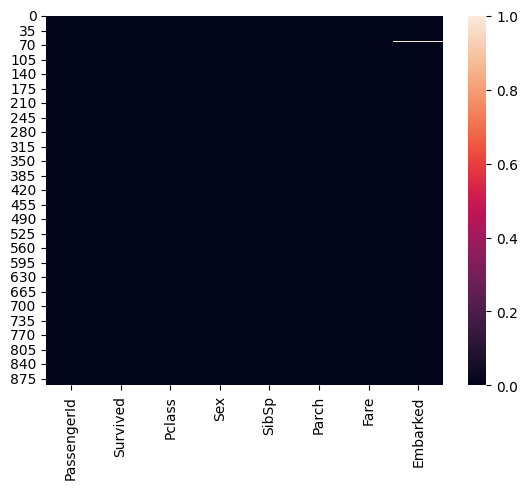

In [64]:
train_df = train_df.drop(columns=['Age','Cabin','Name','Ticket'])
sns.heatmap(train_df.isnull())

## Separating the fearures from the target

In [65]:
X = train_df.drop( columns = "Survived")
y = train_df["Survived"]

# Train and test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 10)

## Building a pipeline training

In [66]:
# more info : https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

estimators = [
    ('encoder', TargetEncoder()),   # standard preprocessing to transform categorical data to numerical 
    ('clf', XGBClassifier(random_state = 10))  # sklearn wrapper implementation of xgboost classification | can be customised objevtive function with the object paraneter
]
pipe = Pipeline(steps = estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=10, ...))])

## Set up hyperparameter tuning

In [67]:
## 'clf__[]' are the hyper parameters

search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode': Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV( pipe, search_space, cv=10, n_iter =50, scoring='roc_auc', random_state=8)
# in reality, you may conseíder setting cv and n_iter to higher values

## Training the XGBoost model

In [68]:
opt.fit(X_train,y_train)

BayesSearchCV(cv=10,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None, gpu_id=None,
                                                       grow_policy=None,
                                                       importance_type=...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

## Model Evaluation and Prediction

In [69]:
# display the parameter values of the best estimator
opt.best_estimator_

Pipeline(steps=[('encoder', TargetEncoder(cols=['Sex', 'Embarked'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.5122456621077666,
                               colsample_bynode=0.8266131103260421,
                               colsample_bytree=0.93918316840611,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=2.6455611169504154,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.010728995971050643, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=10, ...))])

In [70]:
# To see the 'roc-auc' score of the data set
opt.best_score_

0.8583556188175752

In [71]:
# Now we compare this score on the test data set
opt.score(X_test, y_test)

0.8407672170761175

In [72]:
test_pred = opt.predict(X_test)

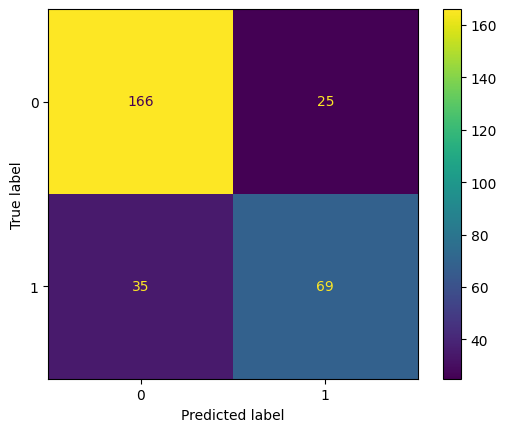

In [73]:
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=opt.classes_)
disp.plot()

## Prediction of the test sample 

In [78]:
test_df = pd.read_csv('data_sets/test.csv')
ori_test_df = test_df.copy()  # copying original test set for later usage

# drop the columns 'Name', 'Age', 'Cabin' & 'Ticket'
test_df = test_df.drop(columns = ['Name', 'Age', 'Cabin', 'Ticket'], axis =1)

In [79]:
test_predictions = opt.predict(test_df)

In [81]:
ori_test_df["Prediction_survived"] = test_predictions
ori_test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prediction_survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [82]:
# write the predictions to a .csv file
ori_test_df.to_csv('with_xgboost_predictions.csv')